In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Convert MNIST image files into tensor of 4-Dimensions (# number of images, Height, Width, Color Channel)
transform = transforms.ToTensor()


In [4]:
#Train Data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

In [5]:
#Test Data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [21]:
#Create a small batch size for images, lets say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [22]:
#Define Our CNN model
#Descrie convoluational layer and what it's doing (2 convolutional layers)
#This is just an example
convo1 = nn.Conv2d(1, 6, 3, 1)
convo2 = nn.Conv2d(6, 16, 3, 1)


In [24]:
#Grab 1 MNIST record/image
for i, (X_Train, y_train) in enumerate(train_data):
    break

In [26]:
X_Train.shape

torch.Size([1, 28, 28])

In [27]:
x = X_Train.view(1,1,28,28)

In [29]:
#Perform our first convolution
x = F.relu(convo1(x)) #Rectified Linear Unit for our activation function

In [31]:
#1 single image, 6 filters was asked for, 26x26 from 28x28 because it excluded the unessesary padding in the image
x.shape

torch.Size([1, 6, 26, 26])

In [32]:
#pass thru the pooling layer
x = F.max_pool2d(x,2,2)#kernel of 2 and stride of 2

In [33]:
x.shape#26 / 2 = 13

torch.Size([1, 6, 13, 13])

In [35]:
#Do our second convolutional layer
x = F.relu(convo2(x))

In [37]:
x.shape # Again, we didn't set padding so we lose 2 pixel around outside of image

torch.Size([1, 16, 11, 11])

In [38]:
#Pooling layer
x = F.max_pool2d(x,2,2)

In [39]:
x.shape#11/2 = 5.5 but we round down since we can't invent data to round up

torch.Size([1, 16, 5, 5])

In [40]:
((28-2) / 2 - 2) / 2 # journey of image size

5.5

In [48]:
#Model CLass
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        #Fully Connected Layer
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)#2x2 kernel and stride of 2
        #Second Pass
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)#2x2 kernel and stride of 2
        
        #Re-View to flatten it out
        X = X.view(-1, 16*5*5) #-1 so that we can vary the batch size
        
        #Fully Connected Layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [49]:
#Create an instance of our model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [50]:
#Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#Smaller learning rate, longer it will take to train

In [52]:
import time 
start_time = time.time()

#Create variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#For Loop of Epochs
for i in range(epochs):
    train_corr = 0
    test_corr = 0
    #Train
    for b,(X_train, y_train) in enumerate(train_loader):
        b+=1#start batches at 1
        y_pred = model(X_train)#get predicted values from the training set. Not flattened 2d
        loss = criterion(y_pred, y_train)#how off are we? Compare the predictions to the correct answers in y_train
        
        predicted = torch.max(y_pred.data, 1)[1]#add up the number of correct predictions. INdexed off the first point
        batch_corr = (predicted == y_train).sum()#how many we got correct we got correct from this specific batch. 
                                                    #True = 1, false = 0 and add those up
        train_corr += batch_corr#keep track as we go along in training
        #Update our parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #Print out Results
        if b%600 == 0:
            print(f'Epoch: {i}  Batch:{b} Loss{loss.item()}')
    train_losses.append(loss)
    train_correct.append(train_corr)
    #Test
    with torch.no_grad(): #no gradient so we don't update our weights and biases with test data
        for b,(X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]#adding up correct predictions
            test_corr += (predicted == y_test).sum()#true = 1, false = 0, and sum away
        
        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(test_corr)
current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0  Batch:600 Loss0.012505684979259968
Epoch: 0  Batch:1200 Loss0.057655591517686844
Epoch: 0  Batch:1800 Loss0.015625834465026855
Epoch: 0  Batch:2400 Loss0.1324503868818283
Epoch: 0  Batch:3000 Loss0.003808070672675967
Epoch: 0  Batch:3600 Loss0.010613595135509968
Epoch: 0  Batch:4200 Loss0.23633775115013123
Epoch: 0  Batch:4800 Loss0.007425201125442982
Epoch: 0  Batch:5400 Loss0.017431829124689102
Epoch: 0  Batch:6000 Loss0.009718138724565506
Epoch: 1  Batch:600 Loss0.010102563537657261
Epoch: 1  Batch:1200 Loss0.013631263747811317
Epoch: 1  Batch:1800 Loss0.026421785354614258
Epoch: 1  Batch:2400 Loss0.2190006673336029
Epoch: 1  Batch:3000 Loss0.05793539434671402
Epoch: 1  Batch:3600 Loss0.000245834409724921
Epoch: 1  Batch:4200 Loss0.00030721232178620994
Epoch: 1  Batch:4800 Loss0.0005000090459361672
Epoch: 1  Batch:5400 Loss0.006974146701395512
Epoch: 1  Batch:6000 Loss0.0005777432816103101
Epoch: 2  Batch:600 Loss0.026135403662919998
Epoch: 2  Batch:1200 Loss0.001498671947

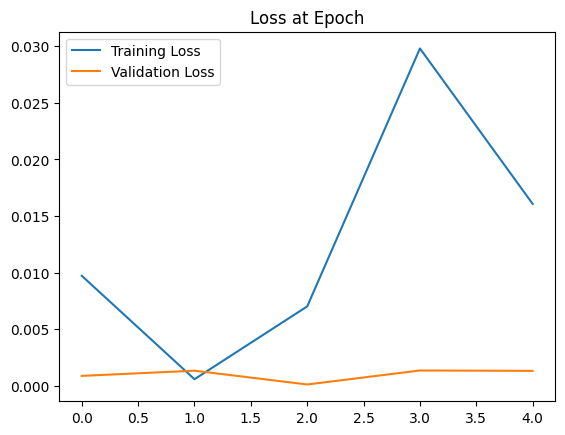

In [54]:
#Graph the loss as epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

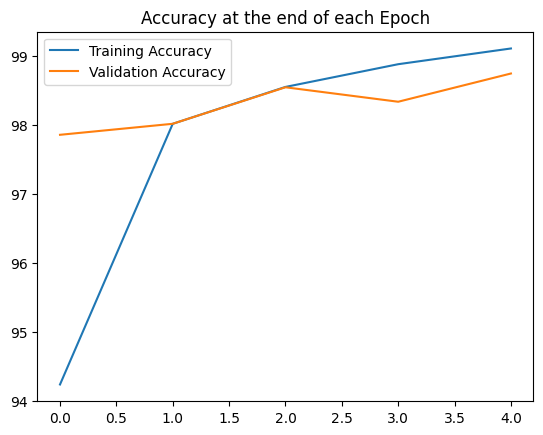

In [58]:
#Graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [59]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle = False)

In [61]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_everything:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [64]:
#Did for correct
correct.item()/len(test_data) * 100

98.75

In [72]:
#Grab an image
test_data[4143] #tensor with an image in it, at the end it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [73]:
#Grab just the data
test_data[1978][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [74]:
#Reshape
test_data[1978][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

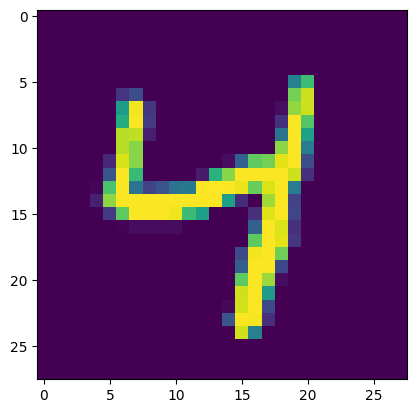

In [75]:
#Show the image
plt.imshow(test_data[1978][0].reshape(28,28))

In [76]:
#Pass the image thru our model
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[1978][0].view(1,1,28,28))#batch size of 1 image, 1 color channel, 28x28 image

In [77]:
#Check the new prediction and get probilities
new_prediction

tensor([[-2.7278e+01, -1.7690e+01, -2.2206e+01, -2.9500e+01, -9.4175e-06,
         -2.1025e+01, -1.9829e+01, -1.8669e+01, -1.7983e+01, -1.1582e+01]])

In [78]:
new_prediction.argmax()

tensor(4)